# Create point source fringe flat

### Define path to data and set flags

### <font color='green'> --Modify following path to the folder where the miri_mrs_point_source_fringes folder resides </font>

In [1]:
user_dir = '/Users/ioannisa/Desktop/python/miri_mrs_point_source_fringes/'

### <font color='green'> --Choose if you wish to save plots (default is True) </font>

In [2]:
save_plots = True

### <font color='red'> --Do NOT change following paths </font>

In [3]:
datapath   = user_dir+'data/'
figurepath = user_dir+'figures/'
outputpath = user_dir+'output_files/'

In [4]:
import itertools
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import sys
sys.path.append(user_dir)
from core.funcs import detpixel_trace_compactsource

In [5]:
%matplotlib notebook

### Preamble

### --Functions

In [6]:
def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z = z + a * x**j * y**i
    return z

def FPfunc_wPhaseShift(wavenumber,T,D,phi):
    """
    Fringe-free continuum is where: sin(delta/2) = 1 ==> 1 / (1 + F) = T
    ==> (1 + F) = 1/T ==> F = 1/T -1
    """
    F = 1/T -1
    return (1 + F * np.sin(2*np.pi*D*wavenumber + phi)**2 )**-1

### --MRS auxilliary data

In [7]:
band = '1A'
nslices = 21

# fringe flat parameters
transm_min = 0.6  # transmission is unitless
transm_max = 1.0  # transmission is unitless
dist_min   = -0.5 # arcseconds
dist_max   = 0.5  # arcseconds

### --Load distortion maps

In [8]:
d2cMaps = {'sliceMap':np.load(datapath+'sliceMap.npy'),
           'lambdaMap':np.load(datapath+'lambdaMap.npy'),
           'alphaMap':np.load(datapath+'alphaMap.npy'),
           'betaMap':np.load(datapath+'betaMap.npy'),
           'nslices':nslices}

### --Load data

In [9]:
sci_img = fits.open(datapath+'CV2_P0.fits')[1].data
fringe_flat = np.load(datapath+'fringe_flat.npy')

### --Load centroid from notebook 0

<IPython.core.display.Javascript object>


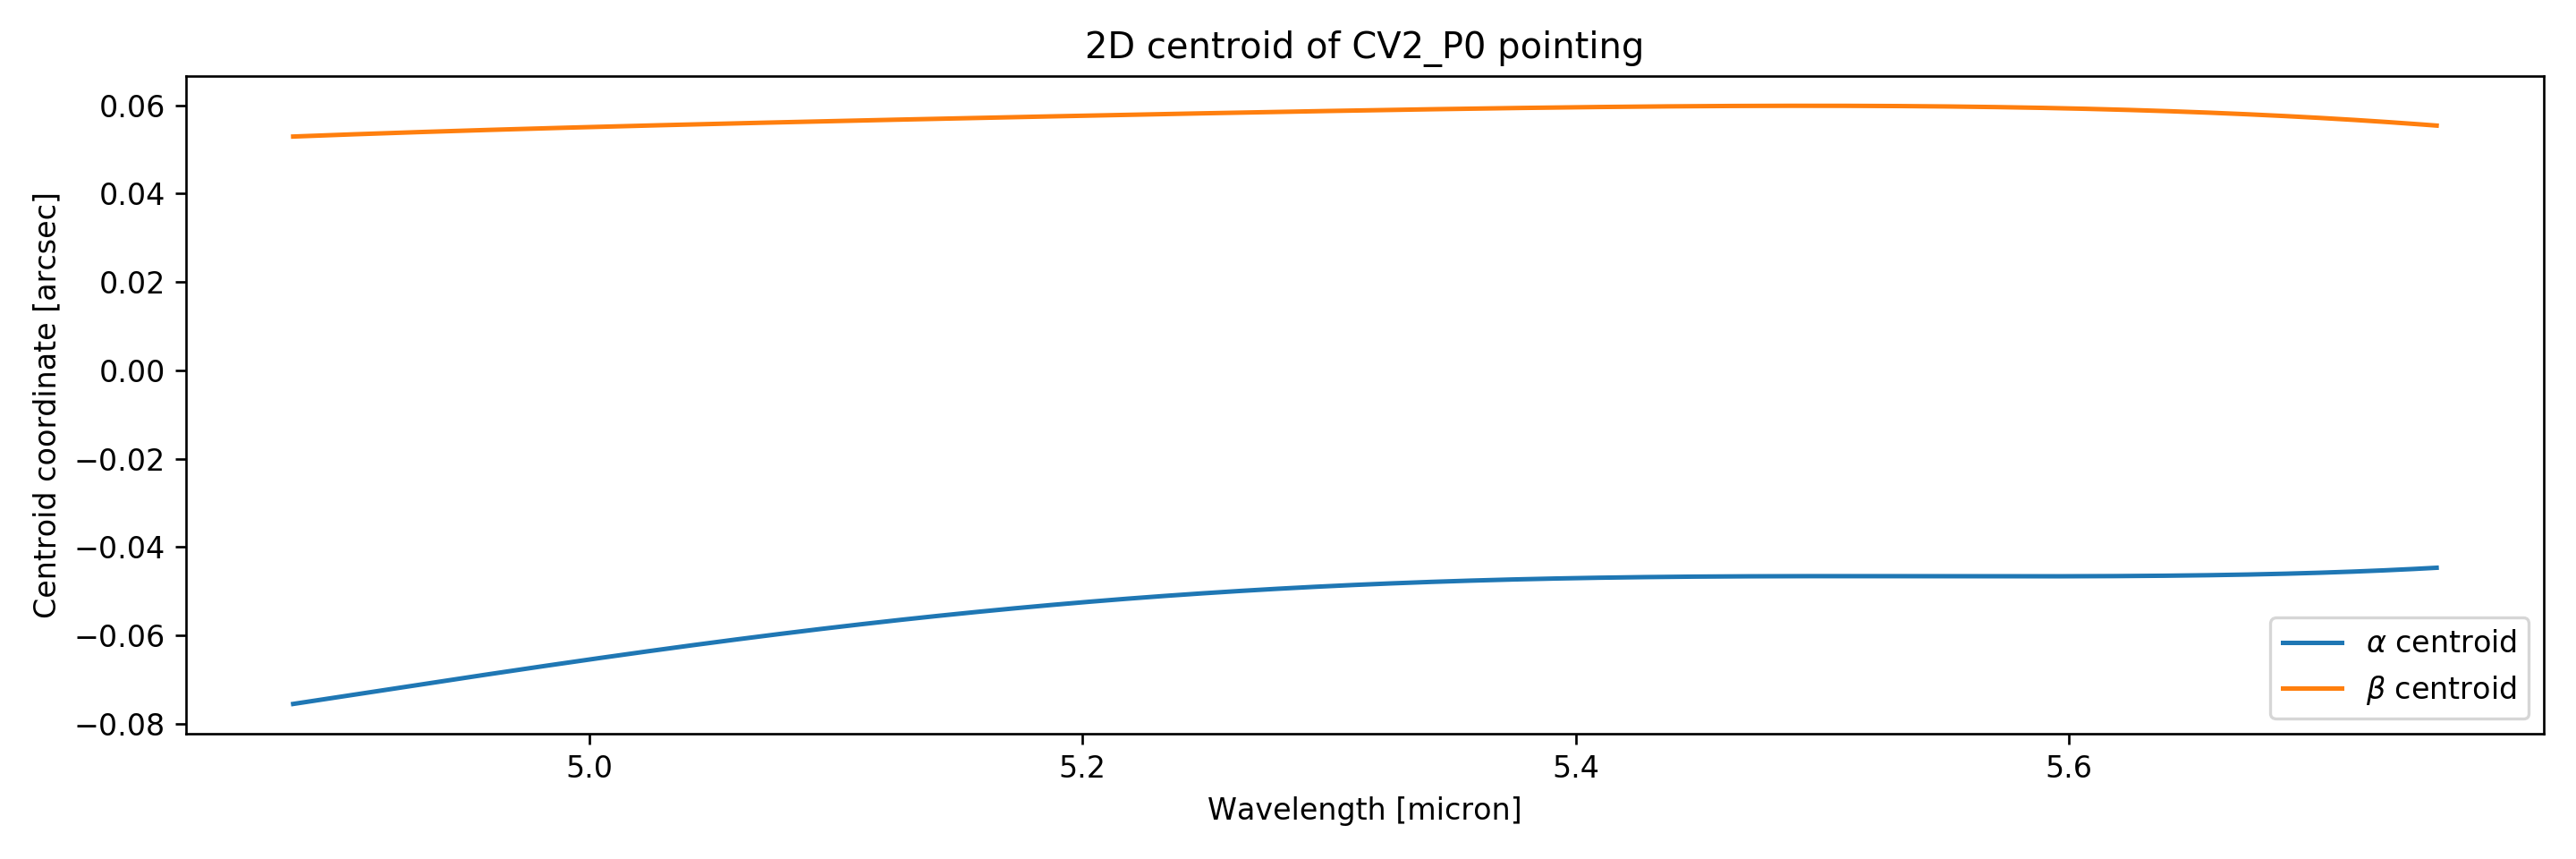

In [10]:
lambcens   = np.load(outputpath+'lambcens.npy') # micron
wavenumber = (10000./lambcens) # cm^-1

popt_alpha = np.load(outputpath+'CV2_P0_alpha_cen_polyfit.npy')
poly_alpha = np.poly1d(popt_alpha)

popt_beta  = np.load(outputpath+'CV2_P0_beta_cen_polyfit.npy')
poly_beta = np.poly1d(popt_beta)

plt.figure(figsize=(12,4))
plt.plot(lambcens,poly_alpha(lambcens),label=r'$\alpha$ centroid')
plt.plot(lambcens,poly_beta(lambcens),label=r'$\beta$ centroid')
plt.title('2D centroid of CV2_P0 pointing')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Centroid coordinate [arcsec]')
plt.legend()
plt.tight_layout()

### --Load results from notebooks 1, 2, and 3

In [11]:
fringe_depth_polyfit_weights = np.load(outputpath+'fringe_depth_polyfit_weights.npy')
fringe_phase_polyfit_weights = np.load(outputpath+'fringe_phase_polyfit_weights.npy')
detector_optical_thickness   = np.load(outputpath+'detector_optical_thickness.npy')

### Fringe analysis

### --Define source position

In [12]:
# PSF centroid in alpha
distMap = poly_alpha(d2cMaps['lambdaMap'])

# PSF centroid in beta
ypos,xpos = detpixel_trace_compactsource(sci_img,band,d2cMaps,offset_slice=0)
xpos = (np.ones(len(ypos))*xpos[512]).astype(int)

centroid_slice = int(d2cMaps['sliceMap'][ypos,xpos][512]-100*int(band[0]) )
print('Centroid slice: {}'.format(centroid_slice))

Centroid slice: 11


### --Derive point source fringe flat based on source position

/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sin
  from ipykernel import kernelapp as app
/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/ioannisa/Applications/anaconda3/envs/miricle.devel/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


<IPython.core.display.Javascript object>


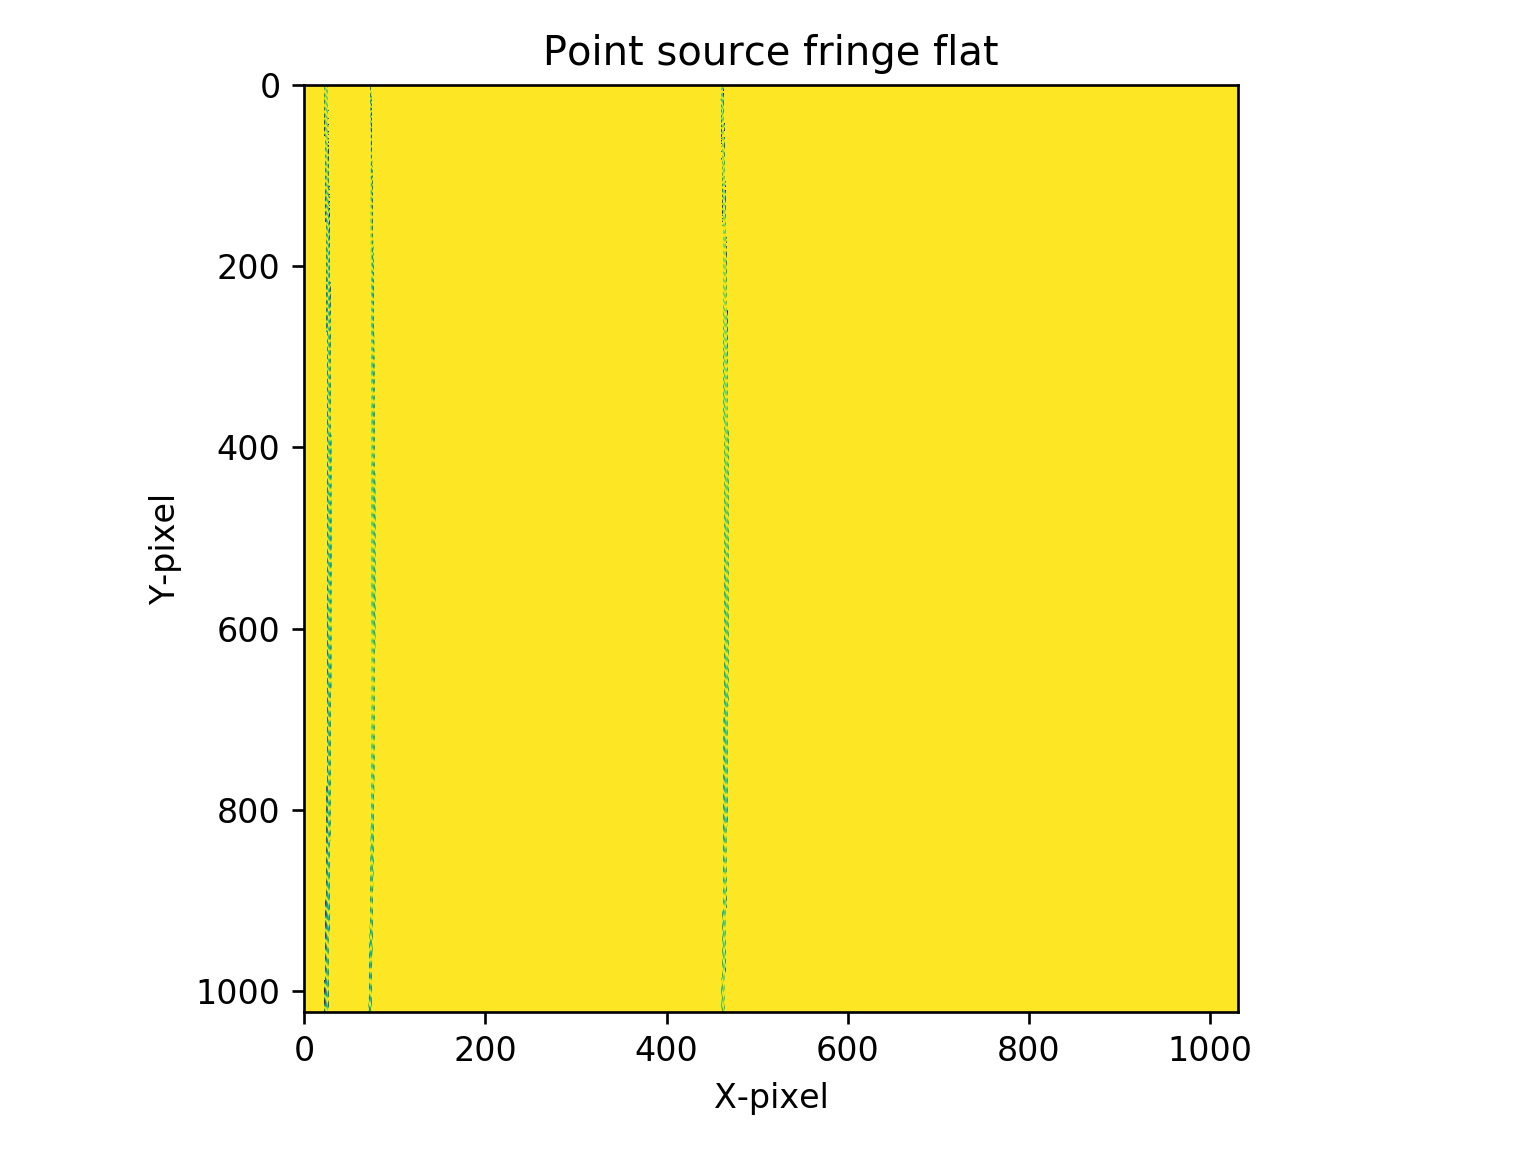

In [13]:
fringe_depth_img = np.ones(d2cMaps['sliceMap'].shape)
fringe_phase_img = np.zeros(d2cMaps['sliceMap'].shape)
for slice_offset in [-1,0,1]:
    sel = ((d2cMaps['sliceMap']-100*int(band[0]) ) == centroid_slice+slice_offset) & (d2cMaps['alphaMap']-distMap>dist_min) & (d2cMaps['alphaMap']-distMap<dist_max)
    x = (d2cMaps['alphaMap']-distMap)[sel] # distance from PSF peak [arcsec]
    y = 10000./d2cMaps['lambdaMap'][sel]   # wavenumber [cm^{-1}]
    
    fringe_depth_polynomial_coeffs = fringe_depth_polyfit_weights[slice_offset+1,:]
    fringe_phase_polynomial_coeffs = fringe_phase_polyfit_weights[slice_offset+1,:]
    
    fringe_depth_img[sel] = polyval2d(x, y, fringe_depth_polynomial_coeffs)
    fringe_phase_img[sel] = polyval2d(x, y, fringe_phase_polynomial_coeffs)
    
ps_fringe_flat = FPfunc_wPhaseShift(10000./d2cMaps['lambdaMap'],fringe_depth_img,detector_optical_thickness,fringe_phase_img)

sel = (ps_fringe_flat>transm_min) & (ps_fringe_flat<transm_max)
ps_fringe_flat[~sel] = 1

plt.figure()
plt.imshow(ps_fringe_flat,vmin=0.6,vmax=1)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('Point source fringe flat')
plt.tight_layout()

### --Plot fringe correction comparison old vs new

<IPython.core.display.Javascript object>


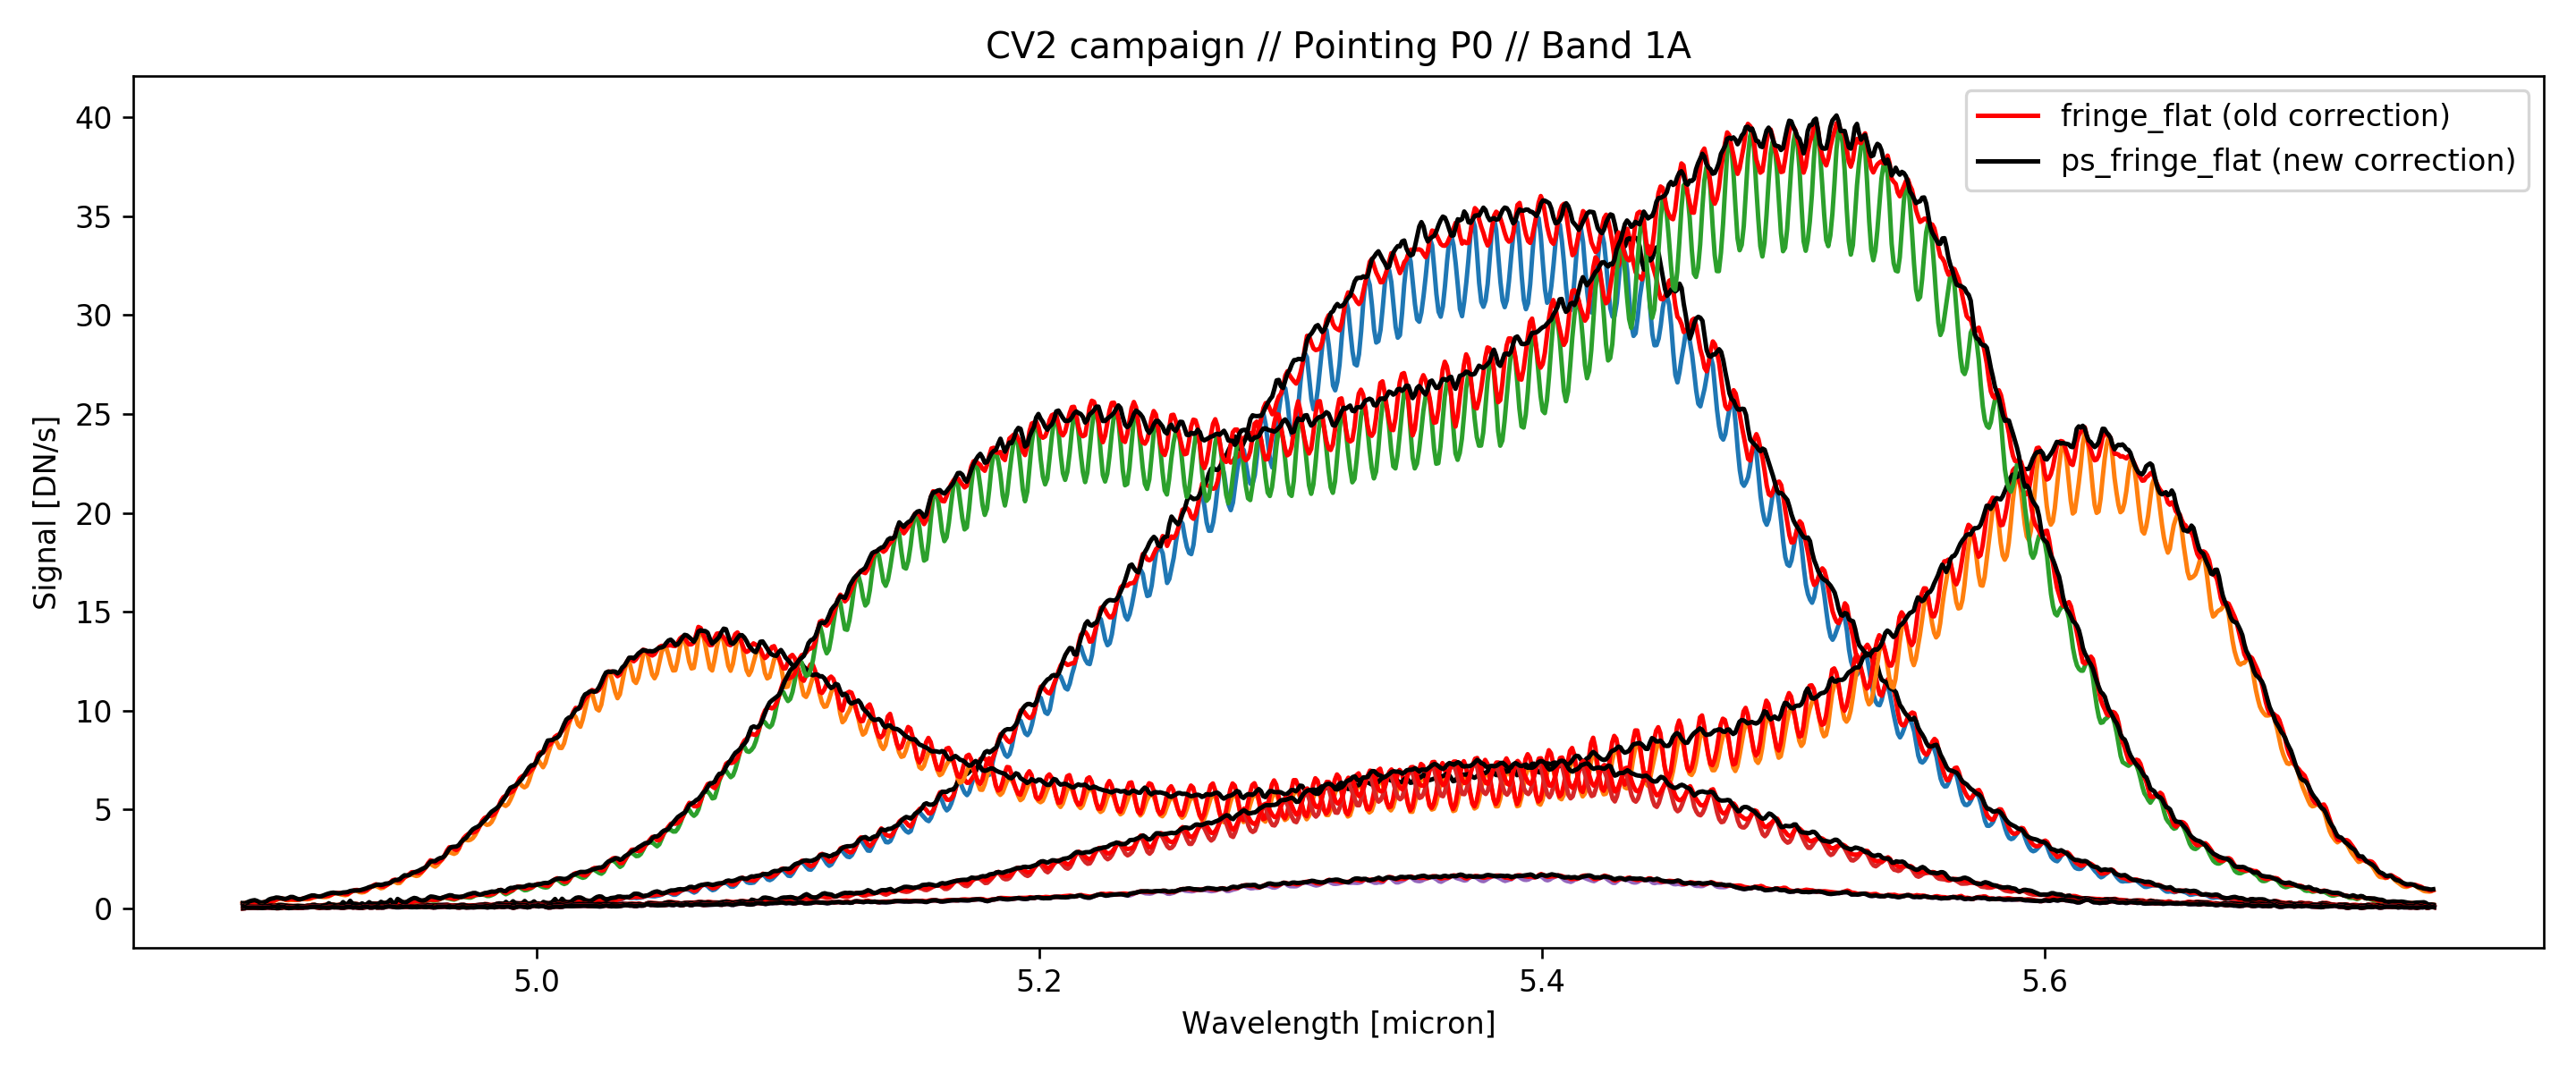

In [14]:
# Three pixel columns in MRS slice
slice_offset = 0

ypos,xpos = detpixel_trace_compactsource(sci_img,band,d2cMaps,offset_slice=slice_offset)
xpos = (np.ones(len(ypos))*xpos[512]).astype(int)

# make first plot of source signal
plt.figure(figsize=(12,5))
for xpos_offset in [0,-2,-1,1,2]:
    wavl = d2cMaps['lambdaMap'][ypos,xpos+xpos_offset]
    extracted_spectrum = sci_img[ypos,xpos+xpos_offset]
    
    omit_nan = ~np.isnan(extracted_spectrum).copy()
    wavl_noNaN = wavl[omit_nan]
    extracted_spectrum_noNaN = extracted_spectrum[omit_nan]
    
    plt.plot(wavl_noNaN,extracted_spectrum_noNaN)
    plt.plot(wavl_noNaN,extracted_spectrum_noNaN/fringe_flat[ypos,xpos+xpos_offset][omit_nan],'r')
    plt.plot(wavl_noNaN,extracted_spectrum_noNaN/ps_fringe_flat[ypos,xpos+xpos_offset][omit_nan],'k')

legend_elements = [Line2D([0],[0],color='r',label='fringe_flat (old correction)'),
                   Line2D([0],[0],color='k',label='ps_fringe_flat (new correction)')]
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/s]')
plt.title('CV2 campaign // Pointing P0 // Band 1A')
plt.legend(handles=legend_elements)
plt.tight_layout()
if save_plots:
    plt.savefig(figurepath+'old_vs_new_fringe_correction.png')

### --Store point source fringe flat

In [16]:
np.save(outputpath+'ps_fringe_flat',ps_fringe_flat)